This notebook is for fine-tuning BERT

In [1]:
# Imports
import os, sys
import numpy as np
import pandas as pd
from gc import collect
from tqdm.notebook import tqdm


import torch
from torch import cuda
from transformers import BertTokenizer, BertModel

device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# Training Data

data = pd.read_csv(r'C:\Users\carte\OneDrive\Desktop\Datascience\SDS\KGA_Bert\data\glue_data\SST-2\train.tsv', sep='\t', header=0)
data = data.sample(frac = 1, ignore_index=True)
data[:5]

,sentence,label
0,an insult to every family,0
1,an `` ambitious failure,0
2,truly magical,1
3,"is a tired one ,",0
4,b-movie scum,0


In [3]:
MAX_LEN = len(max(data.sentence, key=len))
MAX_LEN

268

In [4]:
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 0.0001
NUM_OUT = 1

In [5]:
# Train/Test split
num_examples = len(data)
train_split = int(num_examples * 0.85)

train_data = pd.DataFrame({
    'sentence' : data['sentence'].apply(str.strip)[:train_split],
    'label' : data['label'].apply(int)[:train_split]
}).reset_index()

test_data = pd.DataFrame({
    'sentence' : data['sentence'].apply(str.strip)[train_split:],
    'label' : data['label'].apply(int)[train_split:]
}).reset_index()

In [6]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_size):
        self.sentences = dataset['sentence']
        self.labels = dataset['label']
        self.tokenizer = tokenizer
        self.max_size = max_size

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        text = self.sentences[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_size,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )

        return {'sentences' : torch.tensor(inputs['input_ids'], dtype=torch.long, device=device),
                'mask' : torch.tensor(inputs['attention_mask'], dtype=torch.long, device=device),
                'token_type_ids': torch.tensor(inputs["token_type_ids"], dtype=torch.long, device=device),
                'labels' : torch.tensor(self.labels[idx], dtype=torch.float, device=device)}

In [7]:
class DefaultBERTClass(torch.nn.Module):

    def __init__(self) -> None:
        super(DefaultBERTClass, self).__init__()
        
        self.bert_layer = BertModel.from_pretrained(
            "bert-base-uncased"
            )
        #self.dropout = torch.nn.Dropout(p=0.3)
        self.hidd = torch.nn.Linear(self.bert_layer.config.hidden_size, NUM_OUT)
        self.sig = torch.nn.Sigmoid()
        

    def forward(self, text, attention_mask, token_type_ids):
        embeddings = self.bert_layer(text, attention_mask = attention_mask)
        pooler = embeddings[0][:, 0]
        #dropout = self.dropout(pooler)
        hidden = self.hidd(pooler)
        output = self.sig(hidden)
        return output

In [8]:
from sklearn.metrics import accuracy_score

def loss_fn(outputs, targets):
    return torch.nn.BCELoss()(outputs, targets)

def train(model, optimizer, data_loader):
    model.train()
    for data in tqdm(data_loader):
        inputs = data['sentences']
        mask = data['mask']
        token_type_ids = data['token_type_ids']
        targets = data['labels'].unsqueeze(1)

        #print(inputs, mask)

        outputs = model(inputs, mask, token_type_ids)

        #print(outputs, targets)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Memory optimization
        del inputs, mask, token_type_ids, targets
        collect()
        with torch.cuda.device(device):
            torch.cuda.empty_cache()

    return loss

def validation(model, data_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in tqdm(data_loader):
            inputs = data['sentences']
            mask = data['mask']
            token_type_ids = data['token_type_ids']
            targets = data['labels'].unsqueeze(1)

            outputs = model(inputs, mask, token_type_ids)

            del inputs, mask, token_type_ids
            collect()
            with torch.cuda.device(device):
                torch.cuda.empty_cache()

            fin_outputs.extend(outputs)
            fin_targets.extend(targets)

    return torch.stack(fin_outputs), torch.stack(fin_targets)

def get_accuracy(guess, targs):
    guesses = (guess >= 0.5).cpu().numpy()
    targets = (targs >= 0.5).cpu().numpy()
    return accuracy_score(guesses, targets)

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

training_data = CustomDataset(train_data[:100], tokenizer, MAX_LEN)
training_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

testing_data = CustomDataset(test_data[:100], tokenizer, MAX_LEN)
testing_loader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

def live_plot(accuracies):
    clear_output(wait=True)
    plt.figure()
    plt.xlim(0, EPOCHS)
    plt.ylim(0, 1)
    x= [float(i) for i in range(len(accuracies))]
    y= [float(i) for i in accuracies]
    
    if len(x) > 1:
        plt.plot(x,y)

    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

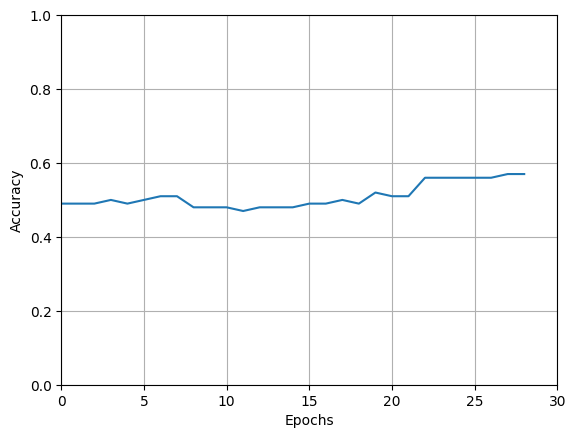

accuracy on test set 0.57


  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\carte\OneDrive\Desktop\Datascience\SDS\KGA_Bert\kga\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


KeyboardInterrupt: 

In [22]:
model = DefaultBERTClass()
optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)

model.to(device)

validation_accuracies = []

for epoch in range(EPOCHS):
    loss = train(model, optimizer, training_loader)
    print(f'Epoch: {epoch}, Loss:  {loss.item()}')
    guess, targs = validation(model, testing_loader)

    #print(guess, targs)
    
    accuracy = get_accuracy(guess, targs)
    validation_accuracies.append(accuracy)

    live_plot(validation_accuracies)

    print('accuracy on test set {}'.format(accuracy))